In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("archive/IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
# # в таргетах пристуня html - розмітка. Приберемо її
# import re

# html_trigger = r"<.*?>"
# df["review"] = df["review"].map(lambda x: re.sub(html_trigger, "", x))

In [4]:
# метод вище не гарантує видалення спецсимволів html, тож кращє використаємо більш повільний, але більш надійний метод для конкретно цієї задачі
from bs4 import BeautifulSoup  # pip3 install bs4

df["review"] = df["review"].map(lambda x: BeautifulSoup(x, "html.parser").get_text())

/tmp/ipykernel_4727/1380122713.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["review"] = df["review"].map(lambda x: BeautifulSoup(x, "html.parser").get_text())


<BarContainer object of 2 artists>

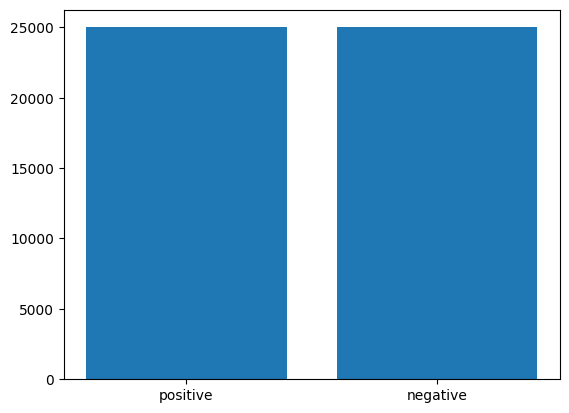

In [5]:
target_count = df["sentiment"].value_counts()

plt.bar(target_count.index, target_count.values)

# маємо збалансований датасет за розподілом таргетів

In [6]:
df["sentiment"] = (df["sentiment"].map({"positive": 1, "negative": 0})).astype("Int16")
# перевели таргети в числовий формат. Так як таргет може бути 1 або 0 - переводимо його сміло в мінімальний, за використанням пам'яті, тип

In [7]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


BAG OF WORDS

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df["review"], df["sentiment"], test_size=.2, shuffle=True, stratify=df["sentiment"])

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
model_pipeline = make_pipeline(
    # CountVectorizer(min_df=.1, max_df=.9),
    CountVectorizer(),
    # LogisticRegression(random_state=42, n_jobs=-1, max_iter=750)
    LogisticRegression(random_state=42, n_jobs=-1)
)

In [11]:
model_pipeline.fit(X_train, y_train)

pred_res = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, pred_res)
accuracy
# отримали 89% точності на логістичній регресії. Вцілому непогано, але я раніше підгледів, що ми маємо 108 тисяч фіч. # 750 ітерацій
# 77% з min_df=.1, max_df=.9
# 83.9% з min_df=.05, max_df=.9
# 83.8% з min_df=.05, max_df=.95
# бачимо, що зі зменшенням кількості токенів знижується точність. Це може бути обумовлено в тому числі тим, що ми маємо невелику кількість 
# речень на відмінних від англійської мовах


0.8857

In [ ]:
from sklearn.model_selection import GridSearchCV
#  Спробуємо покрутити гіперпараметри моделі та Векторайзера. Заодно подивимось як крутити праметри для кроків конвеєра.
# UPD: довелось значно знизити свої побажання по асортименту параметрів, завдяки тому що деякі кроки виконувались по 17 - 25 секунд. Хотілось бі здати домашку щє в цьому році

In [42]:
param_grid = {
    # CountVectorizer
    #"countvectorizer__ngram_range": [(1, 1), (1, 2)], # то дуже багато часу, а в GPU sklearn не вміє
    "countvectorizer__binary": [True, False],
    # LogisticRegression
    "logisticregression__tol": np.linspace(.0001, .001, 3),
    "logisticregression__C": [0.01, 0.1, 1, 5],  
    "logisticregression__max_iter": [750, 1500],

}

grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=5,  
    n_jobs=-1, 
    verbose=2
)


In [ ]:
grid_search.fit(X_train, y_train)

In [44]:
best_params = grid_search.best_params_
best_pipeline = grid_search.best_estimator_

for param, value in best_params.items():
    print(f"{param}: {value}")

countvectorizer__binary: False
logisticregression__C: 0.1
logisticregression__max_iter: 750
logisticregression__tol: 0.0001


In [ ]:
res_best_boosting = best_pipeline.predict(X_test)
accuracy_res_best_boosting = accuracy_score(y_test, res_best_boosting)
accuracy_res_best_boosting

# нам вдалось знайти трохи кращі параметри і підвищіти точність майже на 1%

0.8946

In [14]:
import lightgbm as lgb
# Заради повторення матеріалу та порівняння

In [15]:
# LGBMClassifier ругається на значення типу int та бажає отримувати значення типу np.float, задля загального розвитку ми не відмовимось від використання конвеєрів
# тож напишемо простий клас, який буде конвертувати дані у потрібний нам тип. Для використання у пайплайні клас має реалізовувати 2 обов'язкових методи:
# fit та transform

from sklearn.base import BaseEstimator, TransformerMixin

class Converter(BaseEstimator, TransformerMixin):
    def __init__(self, to_type):
        super().__init__()
        self.to_type = to_type
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.astype(self.to_type)


In [16]:
lgb_pipeline = make_pipeline(
    CountVectorizer(),
    Converter(to_type=np.float32),
    lgb.LGBMClassifier(random_state=42, n_jobs=-1, n_estimators=1000)
)

lgb_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 20000, number of negative: 20000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.492296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60967
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 15828
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('converter', Converter(to_type=<class 'numpy.float32'>)),
                ('lgbmclassifier',
                 LGBMClassifier(n_estimators=1000, n_jobs=-1,
                                random_state=42))])

In [ ]:
pred_res = lgb_pipeline.predict(X_test)
accuracy_lgb = accuracy_score(y_true=y_test, y_pred=pred_res)
accuracy_lgb

# n_estimators == 100 > 86%
# n_estimators == 200 > 88.7%
# n_estimators == 300 > 89.1%
# n_estimators == 400 > 89.57%
# n_estimators == 600 > 89.65%
# n_estimators == 600 > 89.88%
# n_estimators == 900 > 90.04%
# n_estimators == 2000 > 89.94%
# n_estimators == 1500 > 89.29%
# fixme: якщо встигнеш - реалізуй пібір кількості естіматорів бінарним пошуком та намалюй графік accuracy / n_estimators
# як бачимо, застосовуючи boosting ми можемо досягти трохи кращих результатів ніж з використанням логістичної регресії, але час навчання та предікту значно збільшуються

0.8932

TF_IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tfidf_logistic_pipeline = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
)

tfidf_logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=42))])

In [ ]:
tfidf_res = tfidf_logistic_pipeline.predict(X_test)
accuracy_tfidf = accuracy_score(y_test, tfidf_res)
accuracy_tfidf
# маємо схожу точність як із з BoW: 0.8958
# при stop_words == "english" спостерігаємо деяке погіршення accuracy: 0.8896

0.8958

In [21]:
# цікаво що буде зі stacking
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

In [34]:
estimators = [
    # ("regressor", LogisticRegression(random_state=42, n_jobs=-1)),e
    ("kneighbors",  KNeighborsClassifier()),
    ("randomforest", RandomForestClassifier(random_state=42)),
    ("sgd", SGDClassifier(random_state=42)),
    ("ridge", RidgeClassifier(random_state=42)),
    ("lgb", lgb.LGBMClassifier(random_state=42, n_jobs=-1)),
    # ("tree", DecisionTreeClassifier(random_state=42, min_samples_split=5, min_samples_leaf=2))
]

stacking_tfidf_pipeline = make_pipeline(
    TfidfVectorizer(),
    StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
)

In [35]:
stacking_tfidf_pipeline.fit(X_train, y_train)





[LightGBM] [Info] Number of positive: 20000, number of negative: 20000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 9.737532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 806343
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 15828
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 16000, number of negative: 16000
[LightGBM] [Info] Number of positive: 16000, number of negative: 16000
[LightGBM] [Info] Number of positive: 16000, number of negative: 16000
[LightGBM] [Info] Number of positive: 16000, number of negative: 16000
[LightGBM] [Info] Number of positive: 16000, number of negative: 16000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.796806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('kneighbors',
                                                 KNeighborsClassifier()),
                                                ('randomforest',
                                                 RandomForestClassifier(random_state=42)),
                                                ('sgd',
                                                 SGDClassifier(random_state=42)),
                                                ('ridge',
                                                 RidgeClassifier(random_state=42)),
                                                ('lgb',
                                                 LGBMClassifier(n_jobs=-1,
                                                                random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

In [ ]:
stacking_tfidf_res = stacking_tfidf_pipeline.predict(X_test)

accuracy_stacking_tfidf = accuracy_score(y_test, stacking_tfidf_res)
accuracy_stacking_tfidf

# маємо очікуваного переможця - 90.15% 
# додавши LGBMClassifier - змогли щє трохи підняти accuracy до 90.41
# додавши DecisionTreeClassifier  дотягнули щє пару сотих: 0.9057
# дійсно вдалось відіграти 2 сотих при видаленні базових моделей з від'ємними вагами =)

0.9059

In [37]:
# подивимось, чи не заважають деякі базові моделі навчанню

stackingclassifier = stacking_tfidf_pipeline.named_steps["stackingclassifier"]

for e, c in zip(stackingclassifier.estimators_, list(stackingclassifier.final_estimator_.coef_.flatten())):
    print (e, ":", c)

# LogisticRegression(n_jobs=-1, random_state=42) : -0.18746525348798773
# KNeighborsClassifier() : 1.4957442845516409
# RandomForestClassifier(random_state=42) : 0.615826899043837
# SGDClassifier(random_state=42) : 0.14024187577886982
# RidgeClassifier(random_state=42) : 3.482182579435791
# LGBMClassifier(n_jobs=-1, random_state=42) : 2.4754777326266146
# DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42) : -0.04580494818210637

KNeighborsClassifier() : 1.4969888247038403
RandomForestClassifier(random_state=42) : 0.484637647161213
SGDClassifier(random_state=42) : 0.08439627089072507
RidgeClassifier(random_state=42) : 3.493377770924387
LGBMClassifier(n_jobs=-1, random_state=42) : 2.4520266052576773


In [ ]:
# кажуть, що LogisticRegression та DecisionTreeClassifier мають негативний вплив на загальний результат. Закоментимо їх в пайплайні

In [ ]:
# Висновок: на конкретно цьому датасеті відсутня велика різниця в точності між BoW та TF-IDF. 
# Вдалось на практиці попрацювати з пайплайнами - зручна та корисна штука
# найкращій результат за точнісю, очікувано, - stacking, але з таким часом предікта за такий малий приріст в точності
#  варто замислитись над його реалізацією для real-time задач. 